In [2]:
# 导入依赖库
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical

# 检查CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.network(x)

Using device: cuda


In [3]:
# 初始化环境和网络
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = PolicyNetwork(state_dim, 256, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

In [ ]:
# REINFORCE训练函数
def train_reinforce(n_episodes=1500, gamma=0.99):
    rewards_history = []
    losses = []
    print("开始训练...")
    
    # 按整条轨迹，从轨迹各状态进行损失计算
    for episode in range(n_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        
        # 收集轨迹
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).to(device)
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
        
        # 计算回报
        returns = []
        R = 0
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, device=device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        # 更新策略
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        
        # 这里取单条轨迹，各个状态到终点的归一化累积方差的和，这是高方差的原因。
        policy_loss = torch.stack(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        total_reward = sum(rewards)
        rewards_history.append(total_reward)
        losses.append(policy_loss.item())
        
        # 打印训练数据
        if episode % 50 == 0:
            print(f"轮次 {episode:4d}: 奖励 = {total_reward:6.2f}, "
                  f"最近50轮平均奖励 = {np.mean(rewards_history[-50:]):6.2f}, "
                  f"损失 = {policy_loss.item():.4f}")
        
        # 保存检查点
        if episode % 500 == 0 and episode > 0:
            torch.save(policy.state_dict(), f"cartpole_policy_checkpoint_{episode}.pth")
            print(f"保存检查点：cartpole_policy_checkpoint_{episode}.pth")
    
    # 保存最终模型
    torch.save(policy.state_dict(), "cartpole_policy_final.pth")
    print("最终模型权重已保存为 cartpole_policy_final.pth")
    return rewards_history, losses

In [9]:
# 绘制训练结果
def plot_results(rewards_history, losses):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history, label="Episode Reward", alpha=0.5)
    plt.plot(np.convolve(rewards_history, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("train reward")
    plt.xlabel("episode")
    plt.ylabel("total rewards")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, label="Policy Loss", alpha=0.5)
    plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("train loss")
    plt.xlabel("episode")
    plt.ylabel("loss")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_results.png")
    plt.show()
    print("训练结果已保存为 training_results.png")


In [6]:
# 测试与可视化函数
def test_and_visualize(num_episodes=5):
    test_env = gym.make("CartPole-v1", render_mode="human")
    try:
        policy.load_state_dict(torch.load("cartpole_policy_final.pth", map_location=device))
        print("已加载模型权重：cartpole_policy_final.pth")
    except FileNotFoundError:
        print("错误：未找到模型权重文件。请先运行训练。")
        return []
    
    policy.eval()
    episode_rewards = []
    print("\n开始测试...")
    
    for episode in range(num_episodes):
        state, _ = test_env.reset()
        done = False
        total_reward = 0
        test_env.render()
        print(f"\n测试轮次 {episode}:")
        print("步骤 | 状态 (小车位置, 杆角度) | 动作 | 左移概率 | 右移概率 | 奖励")
        print("-" * 80)
        step = 0
        
        while not done:
            state_tensor = torch.FloatTensor(state).to(device)
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            prob_left = probs[0].item()
            prob_right = probs[1].item()
            
            state, reward, terminated, truncated, _ = test_env.step(action.item())
            done = terminated or truncated
            total_reward += reward
            
            print(f"{step:4d} | {state[0]:.3f}, {state[2]:.3f} | {action.item()} | "
                  f"{prob_left:.3f} | {prob_right:.3f} | {reward:.2f}")
            step += 1
            test_env.render()
        
        episode_rewards.append(total_reward)
        print(f"测试轮次 {episode} 总奖励：{total_reward:.2f}")
    
    test_env.close()
    return episode_rewards


In [7]:
# 运行训练
rewards_history, losses = train_reinforce()

开始训练...
轮次    0: 奖励 =  16.00, 最近50轮平均奖励 =  16.00, 损失 = -0.0424
轮次   50: 奖励 =  47.00, 最近50轮平均奖励 =  26.62, 损失 = 1.0417
轮次  100: 奖励 =  94.00, 最近50轮平均奖励 =  82.86, 损失 = -1.4152
轮次  150: 奖励 =  22.00, 最近50轮平均奖励 = 128.48, 损失 = -2.5667
轮次  200: 奖励 = 244.00, 最近50轮平均奖励 = 149.54, 损失 = -7.5093
轮次  250: 奖励 = 500.00, 最近50轮平均奖励 = 292.06, 损失 = -9.1227
轮次  300: 奖励 = 500.00, 最近50轮平均奖励 = 489.74, 损失 = 14.6349
轮次  350: 奖励 = 436.00, 最近50轮平均奖励 = 419.34, 损失 = -22.9122
轮次  400: 奖励 = 145.00, 最近50轮平均奖励 = 138.52, 损失 = -5.5696
轮次  450: 奖励 = 203.00, 最近50轮平均奖励 = 147.72, 损失 = -2.9119
轮次  500: 奖励 = 481.00, 最近50轮平均奖励 = 366.92, 损失 = -1.6131
保存检查点：cartpole_policy_checkpoint_500.pth
轮次  550: 奖励 = 500.00, 最近50轮平均奖励 = 491.40, 损失 = 6.7713
轮次  600: 奖励 = 500.00, 最近50轮平均奖励 = 465.34, 损失 = -3.5000
轮次  650: 奖励 = 500.00, 最近50轮平均奖励 = 489.60, 损失 = -9.5781
轮次  700: 奖励 = 500.00, 最近50轮平均奖励 = 489.28, 损失 = 1.7983
轮次  750: 奖励 = 500.00, 最近50轮平均奖励 = 485.06, 损失 = 3.2199
轮次  800: 奖励 = 333.00, 最近50轮平均奖励 = 451.62, 损失 = -13.7255
轮次  850: 奖励 = 500.

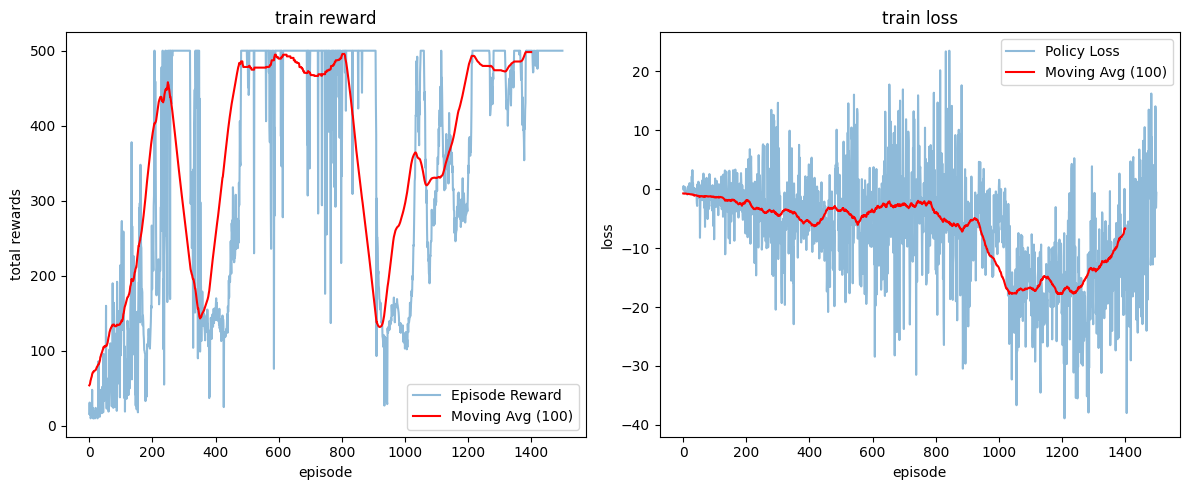

训练结果已保存为 training_results.png


In [10]:
# 绘制训练结果
plot_results(rewards_history, losses)

In [11]:
# 训练评估
avg_train_reward = np.mean(rewards_history[-100:])
print(f"\n训练评估：")
print(f"最后100轮平均奖励：{avg_train_reward:.2f}")
if avg_train_reward > 475:
    print("表现：优秀 - 已解决CartPole（阈值 > 475）")
elif avg_train_reward > 300:
    print("表现：良好 - 稳定但非最优")
else:
    print("表现：需改进")


训练评估：
最后100轮平均奖励：498.18
表现：优秀 - 已解决CartPole（阈值 > 475）


In [12]:
# 运行测试
test_rewards = test_and_visualize()

/tmp/ipykernel_34845/1676314508.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("cartpole_policy_final.pth", map_location=device))


已加载模型权重：cartpole_policy_final.pth

开始测试...

测试轮次 0:
步骤 | 状态 (小车位置, 杆角度) | 动作 | 左移概率 | 右移概率 | 奖励
--------------------------------------------------------------------------------
   0 | 0.027, 0.048 | 0 | 0.428 | 0.572 | 1.00
   1 | 0.024, 0.055 | 1 | 0.020 | 0.980 | 1.00
   2 | 0.025, 0.056 | 1 | 0.231 | 0.769 | 1.00
   3 | 0.030, 0.052 | 0 | 0.947 | 0.053 | 1.00
   4 | 0.031, 0.055 | 1 | 0.129 | 0.871 | 1.00
   5 | 0.036, 0.051 | 0 | 0.899 | 0.101 | 1.00
   6 | 0.036, 0.054 | 1 | 0.070 | 0.930 | 1.00
   7 | 0.041, 0.052 | 0 | 0.792 | 0.208 | 1.00
   8 | 0.042, 0.055 | 1 | 0.040 | 0.960 | 1.00
   9 | 0.047, 0.053 | 1 | 0.601 | 0.399 | 1.00
  10 | 0.055, 0.046 | 0 | 0.976 | 0.024 | 1.00
  11 | 0.060, 0.045 | 1 | 0.432 | 0.568 | 1.00
  12 | 0.068, 0.038 | 0 | 0.967 | 0.033 | 1.00
  13 | 0.073, 0.037 | 0 | 0.304 | 0.696 | 1.00
  14 | 0.074, 0.043 | 1 | 0.015 | 0.985 | 1.00
  15 | 0.078, 0.043 | 1 | 0.182 | 0.818 | 1.00
  16 | 0.087, 0.037 | 0 | 0.924 | 0.076 | 1.00
  17 | 0.091, 0.037 | 1 

In [13]:
# 测试评估
if test_rewards:
    avg_test_reward = np.mean(test_rewards)
    print(f"\n测试评估：")
    print(f"测试轮次平均奖励：{avg_test_reward:.2f}")
    if avg_test_reward > 475:
        print("表现：优秀 - 已解决CartPole（阈值 > 475）")
    elif avg_test_reward > 300:
        print("表现：良好 - 稳定但非最优")
    else:
        print("表现：需改进")


测试评估：
测试轮次平均奖励：500.00
表现：优秀 - 已解决CartPole（阈值 > 475）
